# Imports

In [2]:
import pandas as pd; import seaborn as sb; import statsmodels.formula.api as smf; import pingouin;
from statannot import add_stat_annotation; from itertools import combinations; import os;
from analysis_helpers import *; import scipy; from scipy import stats; import os; import math;
import warnings
warnings.filterwarnings('ignore')

# Load and organize data

In [3]:
# load gaze data
whole_exp1_gaze = pd.DataFrame.from_csv('../parsed_data/gaze_data_exp1.csv')
whole_exp2_gaze = pd.DataFrame.from_csv('../parsed_data/gaze_data_exp2.csv')

# load behavioral data
exp1 = pd.DataFrame.from_csv('/Users/kirstenziman/Documents/NEW_DIRECTORY/new_place/attention-memory-task/parsed_data/behavioral_data_exp1.csv')
exp2 = pd.DataFrame.from_csv('/Users/kirstenziman/Documents/NEW_DIRECTORY/new_place/attention-memory-task/parsed_data/behavioral_data_exp2.csv')

In [4]:
# remove underscores from Subject labels in exp2, convert all Sub #'s to int
whole_exp2_gaze['Subject'] = whole_exp2_gaze['Subject'].astype(str)
whole_exp2_gaze['Subject'] = whole_exp2_gaze['Subject'].map(lambda x: x.rstrip('_'))
whole_exp2_gaze['Subject'] = whole_exp2_gaze['Subject'].astype(int)

# Tendency to gaze towards cued side

In [5]:
gaze_grp_list = []

for data,behav,label in zip([whole_exp1_gaze, whole_exp2_gaze],[exp1, exp2],['1','2']):
    
    # Make sure behavioral data trials are numbered
    behav.loc[behav['Trial Type']=='Memory','Trial'] = list(range(0,40))*30*8
    behav.loc[behav['Trial Type']=='Presentation','Trial'] = list(range(0,10))*30*8
    
    # group gaze data
    gaze_grp = data.groupby(['Subject','Run','Trial'], as_index=False).mean()
    gaze_grp['Run'] = pd.to_numeric(gaze_grp['Run'])
    gaze_grp_list.append(gaze_grp)
    
    # add av x coord to each presentation trial in behavioral df
    for s in gaze_grp['Subject'].unique():

        # special case for subject 327 (three digit subject #, as opposed to 2 digit)
        if label=='2' and s == 32:
            for r in gaze_grp[gaze_grp['Subject']==s]['Run'].unique():
                for t in gaze_grp[(gaze_grp['Subject']==s) & (gaze_grp['Run']==r)]['Trial'].unique():

                    if gaze_grp[(gaze_grp['Subject']==s) & (gaze_grp['Run']==r) & (gaze_grp['Trial']==t)].shape[0]>0:

                        behav.loc[(behav['Subject']==327) 
                                     & (behav['Run']==r) 
                                     & (behav['Trial']==t), 'av_x_coord'] =  gaze_grp[(gaze_grp['Subject']==s) 
                                                                                     & (gaze_grp['Run']==r) 
                                                                                     & (gaze_grp['Trial']==t)]['av_x_coord'].item()

        # all others have two digit subject number
        else:
            for r in gaze_grp[gaze_grp['Subject']==s]['Run'].unique():
                for t in gaze_grp[(gaze_grp['Subject']==s) & (gaze_grp['Run']==r)]['Trial'].unique():

                    if gaze_grp[(gaze_grp['Subject']==s) & (gaze_grp['Run']==r) & (gaze_grp['Trial']==t)].shape[0]>0:

                        behav.loc[(behav['Subject']==s) 
                                     & (behav['Run']==r) 
                                     & (behav['Trial']==t), 'av_x_coord'] =  gaze_grp[(gaze_grp['Subject']==s) 
                                                                                     & (gaze_grp['Run']==r) 
                                                                                     & (gaze_grp['Trial']==t)]['av_x_coord'].item()

    # compute av x gaze's difference from screen center
    behav['gaze_from_center'] = behav['av_x_coord'] - 59.8/2
    
    # make the difference value negative for opposite facing arrow
    behav['gaze_towards_cued_side'] = behav['gaze_from_center']
    behav.loc[(behav['Cued Side']=='<'),'gaze_towards_cued_side'] = -behav.loc[(behav['Cued Side']=='<')]['gaze_towards_cued_side']
    
    # ttest relative to zero drift! 
    behav_grp = behav.groupby(['Subject'], as_index=False).mean()
    print(scipy.stats.ttest_1samp(behav_grp['gaze_towards_cued_side'],0))
    

Ttest_1sampResult(statistic=1.0682312372901301, pvalue=0.29422810651705567)
Ttest_1sampResult(statistic=2.243446847937628, pvalue=0.03267352635339607)


# Data restricted to gaze between images

Calculation of stim distance from center in degrees visual angle

In [23]:
cent_to_deg((8+(7.11/2)), 57) - cent_to_deg((8-(7.11/2)), 57)

7.000624314313017

In [25]:
cent_to_deg((8+(7.11/2)), 60) - cent_to_deg((8-(7.11/2)), 60)

6.663833689622558

In [26]:
def cent_to_deg(centimeters, distance):
    '''
    input:  stim size in centimeters, participant distance from screen (cm)
    output: stim size in visual angle
    '''
    answer = math.degrees(math.atan(centimeters/distance))
    return(answer)

print('visual degrees of screen: ' + str((cent_to_deg((33.6/2),60)*2))[0:6] + ' x ' + str((cent_to_deg((59.8/2),60)*2))[0:6])
print('visual degrees of a single stimulus: ' + str(cent_to_deg((7/2), 57)*2)[0:6])
# note: these values are calculated only for use in the paper
# the gaze data calculations (below) are carried out in centimeters

visual degrees of screen: 31.284 x 52.977
visual degrees of a single stimulus: 7.0275


In [54]:
restricted_concat = {}
for gaze,label in zip([whole_exp1_gaze, whole_exp2_gaze],['exp1','exp2']):

    gaze['gaze_from_center'] = gaze['av_x_coord'] - (59.8/2)
    
    gaze_restricted = gaze[abs(gaze['gaze_from_center'])<4.5]
    gaze_restricted = gaze_restricted.groupby(['Subject','Run','Trial'], as_index=False).mean()
    
    restricted_behavioral = []

    for s in gaze_restricted['Subject'].unique():
        for r in gaze_restricted[gaze_restricted['Subject']==s]['Run'].unique():
            for t in gaze_restricted[(gaze_restricted['Subject']==s) & (gaze_restricted['Run']==r)]['Trial'].unique():
                restricted_behavioral.append(exp1[(exp1['Subject']==s) & (exp1['Run']==int(r)) & (exp1['Trial']==float(t))])
    
    restricted_concat[label] = pd.concat(restricted_behavioral)

# Attended Category vs Unattended Images

In [55]:
for l in restricted_concat:
    d = restricted_concat[l]

    Cats = []
    Novs = []
    for s in d['Subject'].unique():

        Cats.append(d[(d['Subject']==s) & (d['Attention Level'].isin(['Category','Full']))]['Familiarity Rating'].mean())
        Novs.append(d[(d['Subject']==s) & (d['Attention Level']=='None')]['Familiarity Rating'].mean())

    print(l)
    print(scipy.stats.ttest_rel(Cats, Novs))
    print()

exp1
Ttest_relResult(statistic=5.64690501203505, pvalue=4.213010543953335e-06)

exp2
Ttest_relResult(statistic=4.565701278192598, pvalue=0.0001374052631070721)



# Attended Side vs Unattended Images

In [56]:
for l in restricted_concat.keys():
    d = restricted_concat[l]

    Sides = []
    Novs = []
    
    for s in d['Subject'].unique():

        Sides.append(d[(d['Subject']==s) & (d['Attention Level'].isin(['Full','Side']))]['Familiarity Rating'].mean())
        Novs.append(d[(d['Subject']==s) & (d['Attention Level']=='None')]['Familiarity Rating'].mean())


    print(scipy.stats.ttest_rel(Sides, Novs))
    print()

Ttest_relResult(statistic=6.096032590397525, pvalue=1.2242812736474836e-06)

Ttest_relResult(statistic=4.783862423244354, pvalue=7.979110531768327e-05)



# Plot

In [60]:
gaze_added_mem_dict = {}
gaze_added_mem = []

for data,label in zip([exp1, exp2],['exp1','exp2']):
    print(label)

    for s in data['Subject'].unique():
        print(s)
        for r in data['Run'].unique():
            gaze_added_mem.append(add_gaze(data[(data['Subject']==s) & (data['Run']==r)]))

    gaze_mem = pd.concat(gaze_added_mem)
    gaze_mem.loc[gaze_mem['Attention Level']=='Novel','av_x_coord']=0

    gaze_mem['gaze_towards'] = gaze_mem['av_x_coord'] - (59.8/2)

    gaze_mem.loc[(gaze_mem['Cued Side']=='<') 
                 & (gaze_mem['Attention Level'].isin(['Full', 'Side'])), 'gaze_towards'] = -gaze_mem[(gaze_mem['Cued Side']=='<') 
                                                                                                          & (gaze_mem['Attention Level'].isin(['Full', 'Side']))]['gaze_towards']

    gaze_mem.loc[(gaze_mem['Cued Side']=='>') 
                 & (gaze_mem['Attention Level'].isin(['None', 'Category'])), 'gaze_towards'] = -gaze_mem[(gaze_mem['Cued Side']=='>') & (gaze_mem['Attention Level'].isin(['None', 'Category']))]['gaze_towards']

    gaze_mem_grp = gaze_mem.groupby(['Subject','Attention Level', 'Familiarity Rating','Trial Type'], as_index=False).mean()

    gaze_added_mem_dict[label] = gaze_mem

# Plot

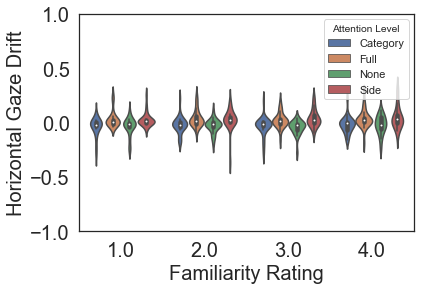

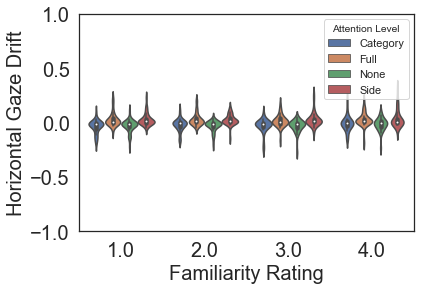

In [43]:
%matplotlib inline
for label in ['exp1','exp2']:
    
    gaze_mem_grp = gaze_added_mem_dict[label].groupby(['Subject','Attention Level', 'Familiarity Rating','Trial Type'], as_index=False).mean()

    # scale by screen size
    gaze_mem_grp['scaled_gaze_towards'] = gaze_mem_grp['gaze_towards']/(59.8/2)

    # plot
    sb.set_style('white')

    f = sb.violinplot(x='Familiarity Rating', y='scaled_gaze_towards', 
                  data=gaze_mem_grp[gaze_mem_grp['Attention Level']!='Novel'], hue='Attention Level')

    plt.grid(False)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.xlabel('Familiarity Rating',    fontsize = 20)
    plt.ylabel('Horizontal Gaze Drift', fontsize = 20)
    f.set(ylim=(-1, 1))
    plt.show()
